# Loan Approval Model

### Hypothesis
Some of my inital thoughts around the topic and data

Applicants are more likely to be approved when: 
- Have a credit history
- Loan Amt : Income ratio is low
- Less dependents
- Married

### Imports

In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import math

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config

import pickle

import json

from pycaret.classification import *
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Functions

In [7]:
def hist(x):
    "returns a widget for histplot"
    return sns.histplot(df[x], kde=True, stat='density', linewidth=0)


## EDA

In [3]:
df = pd.read_csv("../../data/data.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
# lets see what the skew is on these columns
df.skew(axis=0, skipna=True)

/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
Loan_Amount_Term    -2.362414
Credit_History      -1.882361
dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [11]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
# interactive plot for all columns to explore 
interact(hist, x=df.dtypes[df.dtypes != 'object'].index)

interactive(children=(Dropdown(description='x', options=('ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',…

<function __main__.hist(x)>

In [12]:
# lets check for class imbalance
df.groupby('Loan_Status').agg({'Loan_Status':'count'})

,Loan_Status
Loan_Status,
N,192
Y,422


#### Notes from EDA: 
- lots of missing values
- some numerical columns are skewed and not normal
- class status of 2:1 for Y:N

Lets look at just numeric columns

In [13]:
numerics =['int', 'float']
df_numeric = df.select_dtypes(include=numerics)
df_numeric.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


How many applicants have Credit History?

In [20]:
df_numeric.groupby(by=['Credit_History'], 
                   dropna=False).agg(
                       C_H_count = ('ApplicantIncome', 'count'),
                       LoanAmt_mean=('LoanAmount', 'mean'),
                       LoanAmt_median=('LoanAmount', 'median')
                   )

,C_H_count,LoanAmt_mean,LoanAmt_median
Credit_History,,,
0.0,89,146.717647,125.0
1.0,475,144.786026,128.0
NaN,50,161.081633,130.0


In [22]:
interact(hist,
         x=df_numeric.dtypes[df_numeric.dtypes != 'object'].index
        )
# observe that most coapplicant incomes are 0 
# which makes sense as many people ether dont have a coa-applicant (maybe then 0) or there co applicant doesnt have an income

interactive(children=(Dropdown(description='x', options=('ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',…

<function __main__.hist(x)>

Lets look at categorical (nominal) variables

In [23]:
categorical = ['object']
df_categorical = df.select_dtypes(categorical)
df_categorical.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y


In [24]:
df_categorical.nunique()
# shows the unique values per column

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

In [25]:
# exclude loan_id column for continued exploration
df_categorical.drop(columns='Loan_ID').groupby(by='Dependents', dropna=False).agg({'Dependents':'count'})
# can see most applicants have 0 dependents

,Dependents
Dependents,
0,345
1,102
2,101
3+,51
NaN,0


In [27]:
# interactive widget where you can click through dif columns to explore freqency of each class
def count_unique(x):
    return df_categorical.drop(columns='Loan_ID').groupby(by=x, dropna=False).agg({'Loan_Status':'count'})

interact(count_unique,
         x=df_categorical.drop(columns='Loan_ID').columns
        )

interactive(children=(Dropdown(description='x', options=('Gender', 'Married', 'Dependents', 'Education', 'Self…

<function __main__.count_unique(x)>

In [30]:
# lets look at this distribution interactively
interact(hist, x=df.drop(columns='Loan_ID').columns)

interactive(children=(Dropdown(description='x', options=('Gender', 'Married', 'Dependents', 'Education', 'Self…

<function __main__.hist(x)>

Observations from iteractive widget: 
- More applicants are married
- Most applicant are Male 
- Most have no depenents
- Most have graduated from some form of education
- More are NOT self employed
- Property area is somewhat balanced, but most being Semiurban
- More were approved for their applied loan in this dataset

In [31]:
# lets take a look at outliers through iterative widget
def box(x):
    return sns.boxplot(df[x])

interact(box, x=df_numeric.columns)

interactive(children=(Dropdown(description='x', options=('ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',…

<function __main__.box(x)>

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

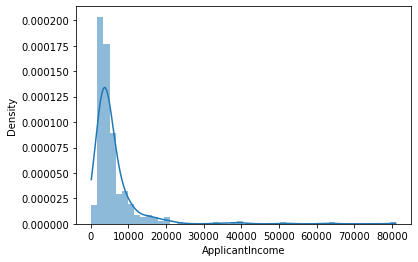

In [32]:
# look at dis of income by education

df_grad = df.loc[df['Education'] == 'Graduate']
df_nograd = df.loc[df['Education'] == 'Not Graduate']

sns.histplot(df_grad['ApplicantIncome'], kde=True, stat='density', linewidth=0, bins=50)

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

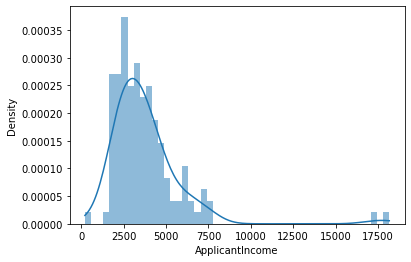

In [33]:
sns.histplot(df_nograd['ApplicantIncome'], kde=True, stat='density', linewidth=0, bins=50)

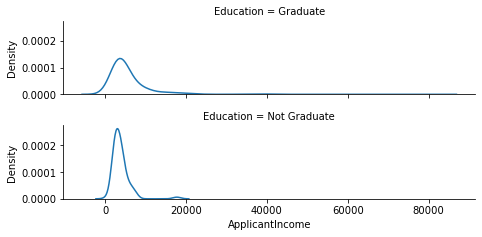

In [34]:
edu_types = df['Education'].value_counts().index
g = sns.FacetGrid(df, row='Education', row_order=edu_types, height=1.7, aspect=4)
g.map(sns.kdeplot, 'ApplicantIncome')

In [36]:
# pivot applicant income w geneder and loan amount
df.pivot_table(values=['ApplicantIncome', 'LoanAmount'], index=['Gender', 'Education'], aggfunc={'LoanAmount':['mean', 'median'], 'ApplicantIncome':'max'}, fill_value=0)

ApplicantIncome  LoanAmount       
                                max        mean median
Gender Education                                      
Female Graduate               19484  129.855556    113
       Not Graduate           18165  111.736842    102
Male   Graduate               81000  157.994490    136
       Not Graduate            7667  119.654206    115

## Data Cleaning

### Missing Values

In [37]:
# missing values 
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [40]:
# filling nulls in gender w the mode
G_mode = df['Gender'].mode().values[0]
df['Gender'] = df['Gender'].fillna(G_mode)

# fix married - made "yes" as that was the mode category
#df.groupby('Married', dropna=False).count() 
M_mode = df['Married'].mode().values[0]
df['Married'] = df['Married'].fillna(M_mode)

# fix dependents 0 - made modes of 0 replace nans
# df.groupby('Dependents', dropna=False).count()
D_mode = df['Dependents'].mode().values[0]
df["Dependents"] = df['Dependents'].fillna(D_mode)

# fix Self_Employed = mode again
# df.groupby('Self_Employed', dropna=False).count()
SE_mode = df['Self_Employed'].mode().values[0]
df['Self_Employed'] = df['Self_Employed'].fillna(SE_mode)

# fix loan amount
LA_mode = df['LoanAmount'].mode().values[0]
df['LoanAmount'] = df['LoanAmount'].fillna(LA_mode)

# fix loan amount term
LAT_mode = df['Loan_Amount_Term'].mode().values[0]
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(LAT_mode)

# fix credit history = put 0 even though mode is 1
#df.loc[df['Credit_History'].isnull()]
df['Credit_History'] = df['Credit_History'].fillna(0)

df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Extreem/skewed Values

<AxesSubplot:xlabel='LoanAmount', ylabel='Count'>

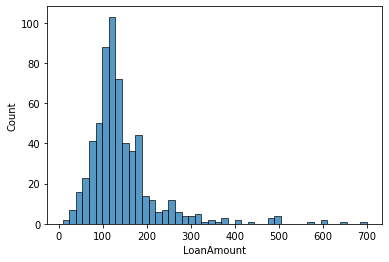

In [41]:
sns.histplot(df['LoanAmount'])

<AxesSubplot:xlabel='LoanAmount', ylabel='Count'>

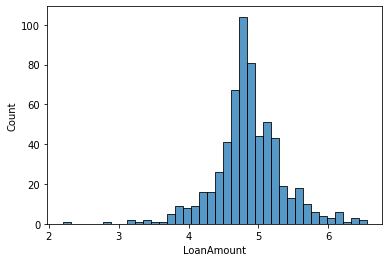

In [42]:
# log the loan amount to normalize
LA_log = df['LoanAmount'].apply(lambda x: math.log(x))
sns.histplot(LA_log)

In [43]:
df['LoanAmount_Log'] = LA_log

Combining both incomes as total income and then take log

In [44]:
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

New feature: loan to total income

In [45]:
ratio = df['LoanAmount'] / df['Total_Income']
df['L_Inc_Ratio'] = ratio

## Modelling Time: 

Approach
![General Flow](../../output/content/process1.png)

In [46]:
# 0 Drop colums
df_clean = df.drop(columns=['Loan_ID', 'LoanAmount'])
df_clean.head()

# in pipeline will need to add feature generation before we drop columns

df_clean['Credit_History'] = df_clean['Credit_History'].astype('int')
cat_columns = df_clean[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']]
num_columns = df_clean[['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'LoanAmount_Log', 'Total_Income', 'L_Inc_Ratio']]

## Encoding Categorical
cols_encoded = pd.get_dummies(cat_columns)

## Scale Numeric
# cols_numeric = df_clean.select_dtypes(numerics)
sc = StandardScaler()
sc.fit(num_columns)
cols_numeric_scaled = sc.transform(num_columns)
cols_numeric_scaled = pd.DataFrame(cols_numeric_scaled, columns=num_columns.columns)

df_processed = pd.concat([cols_numeric_scaled, cols_encoded], axis=1)
df_processed = pd.concat([df_clean['Loan_Status'], df_processed], axis=1)

# train test split
X = df_processed.drop(columns='Loan_Status').to_numpy()
y = df_processed['Loan_Status'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42069)
print(X_train.shape)
print(y_train.shape)

(491, 22)
(491,)


### Model: Logistic Regression Baseline

In [47]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7723577235772358

In [48]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Model: Random Forest Classifier

In [53]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.7723577235772358

### Hyperparamiter tuning

In [56]:
# trying hyper param tuning for RFC
param_grid = {'n_estimators':[70,99,105,120,200, 300],
              'max_depth':[2,4,6,7, 8, 9, 10,20,25,30]}

grid = GridSearchCV(rfc, param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

print(grid.best_estimator_)
grid.best_estimator_.score(X_test, y_test)

RandomForestClassifier(max_depth=6, n_estimators=70)


0.7479674796747967

In [60]:
# try for LR
param_grid = {'penalty': ['elasticnet'],
              'solver':['saga'],
              'max_iter':[100, 500, 5000],
              'l1_ratio':[0,0.00001, 0.0001, 0.1,0.2,0.8,1],
              'C':[0.00001, 0.001, 0.01, 0.1, 0.4, 0.6, 0.7 , 1]}

grid = GridSearchCV(lr, param_grid, n_jobs=1, cv=3)
grid.fit(X_train, y_train)
print(grid.best_estimator_)

/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/josephluiz/miniconda3

LogisticRegression(C=0.4, l1_ratio=0.8, penalty='elasticnet', solver='saga')


/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [61]:
grid.best_estimator_.score(X_test, y_test)
# ok so with LR as a baseline and some tuning we have been able to get 0.788

0.7886178861788617

### Modeling: Pycaret Approach

In [63]:
s = setup(data = df_processed, target='Loan_Status')

,Description,Value
0,session_id,7033
1,Target,Loan_Status
2,Target Type,Binary
3,Label Encoded,"N: 0, Y: 1"
4,Original Data,"(614, 23)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [64]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7527,0.7103,0.8844,0.7765,0.8259,0.4015,0.4180,0.9700
ridge,Ridge Classifier,0.7527,0.0000,0.8773,0.7797,0.8247,0.4067,0.4202,0.0080
lda,Linear Discriminant Analysis,0.7527,0.7089,0.8773,0.7797,0.8247,0.4067,0.4202,0.0130
rf,Random Forest Classifier,0.7411,0.7528,0.8600,0.7785,0.8152,0.3836,0.3956,0.1400
ada,Ada Boost Classifier,0.7317,0.7052,0.8562,0.7699,0.8085,0.3584,0.3714,0.0330
nb,Naive Bayes,0.7225,0.7092,0.8425,0.7670,0.8018,0.3410,0.3474,0.0100
knn,K Neighbors Classifier,0.7181,0.6734,0.9095,0.7336,0.8114,0.2778,0.3062,0.2370
et,Extra Trees Classifier,0.7154,0.7190,0.8287,0.7670,0.7952,0.3289,0.3340,0.1210
lightgbm,Light Gradient Boosting Machine,0.7131,0.7226,0.8110,0.7746,0.7902,0.3344,0.3380,0.0260
gbc,Gradient Boosting Classifier,0.7085,0.6903,0.8318,0.7581,0.7910,0.3087,0.3176,0.0270


In [65]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [66]:
tuned_lr = tune_model(best, fold=4, n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7870,0.7415,0.9167,0.7952,0.8516,0.4812,0.4967
1,0.7570,0.7480,0.9155,0.7647,0.8333,0.3981,0.4208
2,0.7664,0.7246,0.9014,0.7805,0.8366,0.4341,0.4482
3,0.7196,0.6754,0.8333,0.7692,0.8000,0.3337,0.3368
Mean,0.7575,0.7224,0.8917,0.7774,0.8304,0.4118,0.4256
Std,0.0244,0.0284,0.0342,0.0118,0.0188,0.0538,0.0581


In [67]:
optimize_threshold = optimize_threshold(tuned_lr)

/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/josephluiz/miniconda3/envs/THIRD_LOVE/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: Run

In [68]:
predict_model(tuned_lr, probability_threshold=0.2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7459,0.7569,1.0000,0.7432,0.8527,0.0589,0.1742


,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,LoanAmount_Log,Total_Income,L_Inc_Ratio,Gender_Male,Married_Yes,Dependents_0,Dependents_1,...,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Credit_History_1,Loan_Status,Label,Score
0,-0.200434,0.234195,0.273231,0.704107,-0.083476,0.492417,0,1,1,0,...,0,0,0,0,1,0,1.0,Y,Y,0.8839
1,-0.483196,0.243429,0.273231,0.692994,-0.346748,1.623599,1,1,1,0,...,0,1,0,0,0,1,0.0,N,Y,0.2575
2,-0.366552,-0.554487,0.273231,-2.564579,-0.597933,-1.443832,0,1,1,0,...,0,0,0,0,1,0,1.0,Y,Y,0.8890
3,1.572156,-0.554487,0.273231,1.712205,1.235828,-0.442716,1,1,0,0,...,1,0,0,1,0,0,1.0,Y,Y,0.7849
4,-0.134412,1.369336,0.273231,1.384388,0.493274,0.135087,1,1,1,0,...,0,0,0,0,1,0,1.0,Y,Y,0.8610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,0.225840,-0.554487,0.273231,-0.136045,-0.037609,-0.710259,1,0,1,0,...,0,0,0,0,0,1,0.0,N,Y,0.3110
181,-0.463045,0.728062,0.273231,0.340775,-0.108114,0.024132,1,1,1,0,...,0,0,1,1,0,0,1.0,Y,Y,0.7779
182,1.550203,-0.554487,0.273231,-1.223255,1.215064,-2.216734,0,1,0,0,...,0,0,0,0,0,1,1.0,Y,Y,0.8404
183,0.316108,2.295508,-0.658791,0.624995,1.339029,-1.467050,1,1,1,0,...,0,0,0,1,0,0,0.0,Y,Y,0.3714


In [90]:
y_pred = predict_model(tuned_lr, probability_threshold=0.75, verbose=False)["Label"]
y_test = predict_model(tuned_lr, probability_threshold=0.75, verbose=False)["Loan_Status"]

              precision    recall  f1-score   support

           N       0.44      0.67      0.53        49
           Y       0.85      0.69      0.76       136

    accuracy                           0.69       185
   macro avg       0.65      0.68      0.65       185
weighted avg       0.74      0.69      0.70       185



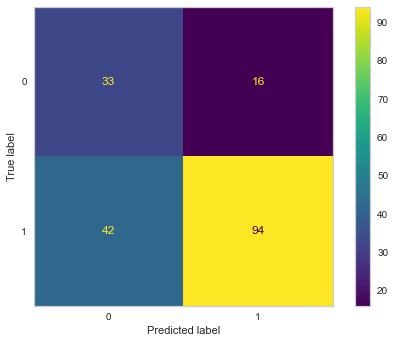

In [91]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='.5g')
print(classification_report(y_test, y_pred))
plt.grid(visible=None)
plt.show()

## Pipeline

1. data in 
2. fill missing values
3. create columns
4. split into cat & num piprlinrs
5. one hot cat / scale num
6. union together
7. pump into model

We will make pipeline that does 4-7 for now

In [93]:
df_clean.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_Log,Total_Income,L_Inc_Ratio
0,Male,No,0,Graduate,No,5849,0.0,360.0,1,Urban,Y,4.787492,5849.0,0.020516
1,Male,Yes,1,Graduate,No,4583,1508.0,360.0,1,Rural,N,4.852030,6091.0,0.021015
2,Male,Yes,0,Graduate,Yes,3000,0.0,360.0,1,Urban,Y,4.189655,3000.0,0.022000
3,Male,Yes,0,Not Graduate,No,2583,2358.0,360.0,1,Urban,Y,4.787492,4941.0,0.024287
4,Male,No,0,Graduate,No,6000,0.0,360.0,1,Urban,Y,4.948760,6000.0,0.023500


In [94]:
df_train, df_test = train_test_split(df_clean, test_size=0.1, shuffle=True, random_state=80085)
print(df_train.shape)
print(df_test.shape)
# use df_train in your pipeline 
# did a 10% holdout for later

# x & y train test split
X = df_train.drop('Loan_Status', axis=1)
y = df_train['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123456)

(552, 14)
(62, 14)


In [95]:
numeric_transform = Pipeline([('scaling', StandardScaler()) # maybe could also fill na with SimpleImputer
                             ])
categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse=False)),
                                 # could use Simple Imputer if we do transformations in here
                                ])

preprocessing_data = ColumnTransformer([('numeric', numeric_transform, ['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'LoanAmount_Log', 'Total_Income', 'L_Inc_Ratio']),
                                   ('categorical', categorical_transform, ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area'])
                                  ])

pipe_loan = Pipeline([('preprocess', preprocessing_data),
                      ('model', LogisticRegression(C=2.082, penalty='l2'))
                     ])

pipe_loan.fit(X_train, y_train)
pipe_loan.score(X_test, y_test)

0.8018018018018018

In [98]:
set_config(display='diagram')
pipe_loan

TypeError: set_config() got an unexpected keyword argument 'display'

In [99]:
# saving model
filename = 'lr_model2.sav'
pickle.dump(pipe_loan, open('../../output/models/' + filename, 'wb'))